In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib


In [3]:
wf_with_features = pd.read_csv("wf_with_features.csv")
wf_with_features["success"] = wf_with_features["fourth_down_converted"]
wf_with_features.head()

,Unnamed: 0,play_id,game_id,home_team,away_team,season,season_type,week,posteam,posteam_type,...,off_int_rate,passing_cpoe,def_epa_play_allowed,def_epa_db_allowed,def_epa_rush_allowed,def_ypa_allowed,def_ypc_allowed,def_sack_rate,def_int_rate_forced,success
0,1,3279,2019_01_ATL_MIN,MIN,ATL,2019,REG,1,ATL,away,...,0.02193,48.175976,-0.049872,-0.018646,-0.097045,6.862385,4.297009,0.052334,0.013761,1
1,2,3882,2019_01_ATL_MIN,MIN,ATL,2019,REG,1,ATL,away,...,0.02193,48.175976,-0.049872,-0.018646,-0.097045,6.862385,4.297009,0.052334,0.013761,1
2,3,1763,2019_01_BAL_MIA,MIA,BAL,2019,REG,1,BAL,away,...,0.02004,53.292072,0.120756,0.239655,-0.018491,7.987156,4.465979,0.102113,0.033028,1
3,4,3451,2019_01_BAL_MIA,MIA,BAL,2019,REG,1,BAL,away,...,0.02004,53.292072,0.120756,0.239655,-0.018491,7.987156,4.465979,0.102113,0.033028,1
4,5,1701,2019_01_BUF_NYJ,NYJ,BUF,2019,REG,1,BUF,away,...,0.02139,-36.328230,-0.049853,0.030581,-0.169444,6.839316,3.335731,0.083871,0.027350,0


# **Logisitc Regression**

In [4]:
# Train and test split by season to avoid spillage
train_seasons = list(range(2019, 2024))
test_season = [2024]

train = wf_with_features[wf_with_features["season"].isin(train_seasons)].copy()
test = wf_with_features[wf_with_features["season"].isin(test_season)].copy()

In [5]:
# Define outcome and candidate features based on the columns
y_col = "success"

num_feats = [
    "ydstogo","yardline_100","game_seconds_remaining","score_differential",
    "off_epa_db","off_epa_rush","def_epa_db_allowed","def_epa_rush_allowed"
]

cat_feats = ["qtr"]

X_log_train = train[num_feats + cat_feats]
y_log_train = train[y_col].astype(int)

X_log_test  = test[num_feats + cat_feats]
y_log_test  = test[y_col].astype(int)


In [6]:
# PreProcess: impute numeric medians, one-hot categorical
pre = ColumnTransformer(
    transformers= [
        ("num", SimpleImputer(strategy= "median"), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ],
    remainder= "drop"
)

In [7]:
# Logistic Model
logistic = LogisticRegression(max_iter= 5000, class_weight= "balanced")

glm = Pipeline(steps=[("pre", pre), ("logit", logistic)])
glm.fit(X_log_train, y_log_train);

In [8]:
# Predict on the test
p_hat = glm.predict_proba(X_log_test)[:, 1]
y_pred_05 = (p_hat >= 0.5).astype(int)

In [9]:
# Metrics 
log_auc = roc_auc_score(y_log_test, p_hat)
log_cm = confusion_matrix(y_log_test, y_pred_05, labels=[0, 1])
log_precision = precision_score(y_log_test, y_pred_05, zero_division= 0)
log_recall = recall_score(y_log_test, y_pred_05, zero_division= 0)
log_acc = accuracy_score(y_log_test, y_pred_05)

print(f"AUC: {log_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(log_cm)
print(f"Precision: {log_precision:.4f}")
print(f"Recall:    {log_recall:.4f}")
print(f"Accuracy:  {log_acc:.4f}")

AUC: 0.6733
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[167 183]
 [100 366]]
Precision: 0.6667
Recall:    0.7854
Accuracy:  0.6532


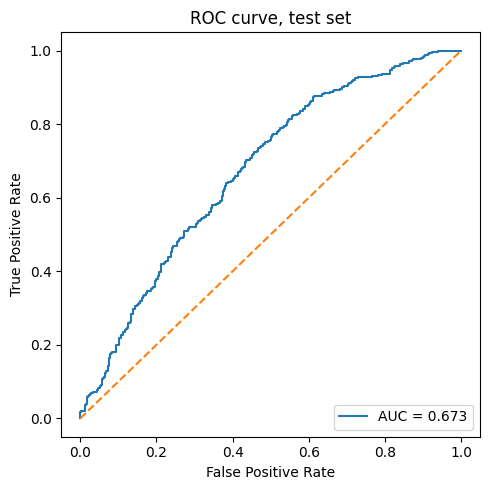

In [10]:
# ROC Plot
fpr, tpr, thr = roc_curve(y_log_test, p_hat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label=f"AUC = {log_auc:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curve, test set")
ax.legend(loc="lower right")
fig.tight_layout()
plt.show()

# **Random Forest Model**

In [11]:
# Train and test split by season to avoid spillage
train_seasons = list(range(2019, 2024))
test_season = [2024]

train = wf_with_features[wf_with_features["season"].isin(train_seasons)].copy()
test = wf_with_features[wf_with_features["season"].isin(test_season)].copy()

In [12]:
# Define outcome and candidate features based on the columns
y_col = "success"

num_feats = [
    "ydstogo","yardline_100","game_seconds_remaining","score_differential",
    "off_epa_db","off_epa_rush","def_epa_db_allowed","def_epa_rush_allowed"
]

cat_feats = ["qtr"]

X_rf_train = train[num_feats + cat_feats]
y_rf_train = train[y_col].astype(int)

X_rf_test  = test[num_feats + cat_feats]
y_rf_test  = test[y_col].astype(int)

In [13]:
# PreProcess: impute numeric medians, one-hot categorical
pre = ColumnTransformer(
    transformers= [
        ("num", SimpleImputer(strategy= "median"), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ],
    remainder= "drop"
)

In [14]:
# RF model
randomf = RandomForestClassifier(
    n_estimators= 800,
    max_depth= None,
    min_samples_leaf=5,
    max_features= "sqrt",
    class_weight= "balanced",
    random_state= 42,
    n_jobs= -1
)

rf = Pipeline(steps = [("pre", pre), ("rf", randomf)])
rf.fit(X_rf_train, y_rf_train);

In [15]:
# Predict
p_hat = rf.predict_proba(X_rf_test)[:, 1]
y_pred_05 = (p_hat >= 0.5).astype(int)

In [16]:
# Metrics
rf_auc = roc_auc_score(y_rf_test, p_hat)
rf_cm = confusion_matrix(y_rf_test, y_pred_05, labels=[0, 1])
rf_precision = precision_score(y_rf_test, y_pred_05, zero_division= 0)
rf_recall = recall_score(y_rf_test, y_pred_05, zero_division= 0)
rf_acc = accuracy_score(y_rf_test, y_pred_05)

print(f"AUC: {rf_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(rf_cm)
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"Accuracy:  {rf_acc:.4f}")

AUC: 0.6700
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[179 171]
 [127 339]]
Precision: 0.6647
Recall:    0.7275
Accuracy:  0.6348


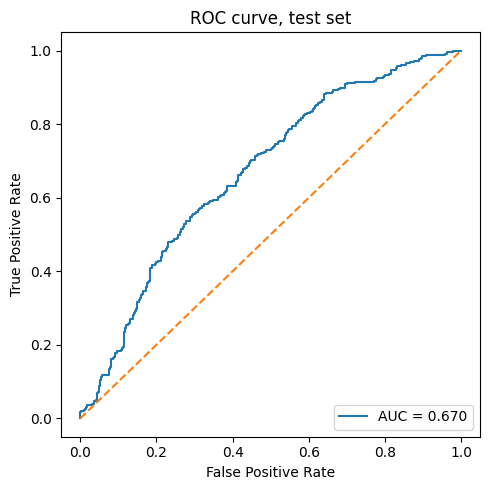

In [17]:
# ROC Plot
fpr, tpr, thr = roc_curve(y_rf_test, p_hat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label=f"AUC = {rf_auc:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curve, test set")
ax.legend(loc="lower right")
fig.tight_layout()
plt.show()

In [18]:
# Feature importance (from RF)
ohe = rf.named_steps["pre"].named_transformers_.get("cat")
num_names = num_feats
cat_names = list(ohe.get_feature_names_out(cat_feats)) if ohe is not None else []
feature_names = num_names + cat_names

importances = rf.named_steps["rf"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}) \
           .sort_values("importance", ascending=False)
print(imp_df.head(20).to_string(index=False))

               feature  importance
               ydstogo    0.174019
game_seconds_remaining    0.142152
            off_epa_db    0.112883
    def_epa_db_allowed    0.111444
          off_epa_rush    0.111126
          yardline_100    0.110228
  def_epa_rush_allowed    0.108659
    score_differential    0.094229
                 qtr_4    0.013444
                 qtr_3    0.009431
                 qtr_2    0.007560
                 qtr_1    0.004708
                 qtr_5    0.000118


# **XGBoost Model**

In [19]:
# Train and test split by season to avoid spillage
train_seasons = list(range(2019, 2024))
test_season = [2024]

train = wf_with_features[wf_with_features["season"].isin(train_seasons)].copy()
test = wf_with_features[wf_with_features["season"].isin(test_season)].copy()

In [20]:
# Define outcome and candidate features based on the columns
y_col = "success"

num_feats = [
    "ydstogo","yardline_100","game_seconds_remaining","score_differential",
    "off_epa_db","off_epa_rush","def_epa_db_allowed","def_epa_rush_allowed"
]

cat_feats = ["qtr"]

X_xg_train = train[num_feats + cat_feats]
y_xg_train = train[y_col].astype(int)

X_xg_test  = test[num_feats + cat_feats]
y_xg_test  = test[y_col].astype(int)

In [21]:
# PreProcess: impute numeric medians, one-hot categorical
pre = ColumnTransformer(
    transformers= [
        ("num", SimpleImputer(strategy= "median"), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ],
    remainder= "drop"
)

In [22]:
# Model (sensible starting hyperparams)
xgb = XGBClassifier(
    objective = "binary:logistic",
    n_estimators = 3000,
    learning_rate = 0.05,
    max_depth = 4,
    min_child_weight = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    n_jobs = -1,
    random_state = 42,
    eval_metric = "auc",
    tree_method = "hist"
)

xgb_pipe = Pipeline(steps = [("pre", pre), ("xgb", xgb)])
xgb_pipe.fit(X_xg_train, y_xg_train);

In [23]:
# Predict
p_hat = xgb_pipe.predict_proba(X_xg_test)[:, 1]
y_pred_05 = (p_hat >= 0.5).astype(int)

In [24]:
# Metrics
xgb_auc = roc_auc_score(y_xg_test, p_hat)
xgb_cm = confusion_matrix(y_xg_test, y_pred_05, labels=[0, 1])
xgb_precision = precision_score(y_xg_test, y_pred_05, zero_division= 0)
xgb_recall = recall_score(y_xg_test, y_pred_05, zero_division= 0)
xgb_acc = accuracy_score(y_xg_test, y_pred_05)

print(f"AUC: {xgb_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(xgb_cm)
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"Accuracy:  {xgb_acc:.4f}")

AUC: 0.6357
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[203 147]
 [183 283]]
Precision: 0.6581
Recall:    0.6073
Accuracy:  0.5956


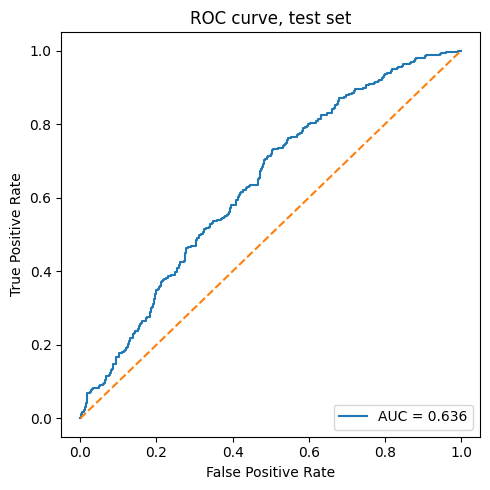

In [25]:
# ROC Plot
fpr, tpr, thr = roc_curve(y_xg_test, p_hat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label=f"AUC = {xgb_auc:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curve, test set")
ax.legend(loc="lower right")
fig.tight_layout()
plt.show()

In [26]:
print(f"AUC: {log_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(log_cm)
print(f"Precision: {log_precision:.4f}")
print(f"Recall:    {log_recall:.4f}")
print(f"Accuracy:  {log_acc:.4f}\n")

print("Random Forest Metrics: ")
print(f"AUC: {rf_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(rf_cm)
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"Accuracy:  {rf_acc:.4f}\n")

print("XGBoost metircs: ")
print(f"AUC: {xgb_auc:.4f}")
print("Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):")
print(xgb_cm)
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"Accuracy:  {xgb_acc:.4f}")

AUC: 0.6733
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[167 183]
 [100 366]]
Precision: 0.6667
Recall:    0.7854
Accuracy:  0.6532

Random Forest Metrics: 
AUC: 0.6700
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[179 171]
 [127 339]]
Precision: 0.6647
Recall:    0.7275
Accuracy:  0.6348

XGBoost metircs: 
AUC: 0.6357
Confusion matrix at 0.5 (rows=actual 0,1; cols=pred 0,1):
[[203 147]
 [183 283]]
Precision: 0.6581
Recall:    0.6073
Accuracy:  0.5956
